In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib notebook
%matplotlib inline

In [2]:
G = nx.read_gpickle('email_prediction_NEW.txt', )

print(nx.info(G))

Graph with 1005 nodes and 16706 edges


C:\Users\rogha\AppData\Local\Temp\ipykernel_17348\1797801492.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [3]:
list(G.nodes(data=True))[:10]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (581, {'Department': 3, 'ManagementSalary': 0.0}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (65, {'Department': 4, 'ManagementSalary': nan}),
 (64, {'Department': 25, 'ManagementSalary': 1.0}),
 (73, {'Department': 1, 'ManagementSalary': 0.0}),
 (74, {'Department': 1, 'ManagementSalary': 0.0}),
 (459, {'Department': 1, 'ManagementSalary': 0.0}),
 (268, {'Department': 39, 'ManagementSalary': 0.0})]

## Salary Prediction

In [4]:
# our df's index will be the nodes (employees)
df = pd.DataFrame(index=G.nodes())

# And the two first features are employee's department and a binary variable 
# equal to 1 if an employee has got a Managemement Salary and 0 otherwise.

df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df.head()

,Department,ManagementSalary
0,1,0.0
1,1,NaN
581,3,0.0
6,25,1.0
65,4,NaN


In [5]:
df['Clust_coef'] = pd.Series(nx.clustering(G))
df['Deg_centr'] = pd.Series(nx.degree_centrality(G))
df['Clos_centr'] = pd.Series(nx.closeness_centrality(G))
df['Betw_centr'] = pd.Series(nx.betweenness_centrality(G))
df['PageR'] = pd.Series(nx.pagerank(G))
df.head()

,Department,ManagementSalary,Clust_coef,Deg_centr,Clos_centr,Betw_centr,PageR
0,1,0.0,0.276423,0.043825,0.421991,0.001124,0.001224
1,1,NaN,0.265306,0.051793,0.422360,0.001195,0.001426
581,3,0.0,0.248276,0.031873,0.412974,0.000378,0.000894
6,25,1.0,0.155183,0.114542,0.475805,0.012387,0.003146
65,4,NaN,0.172880,0.090637,0.461049,0.012473,0.002857


In [6]:
to_predict = df[df['ManagementSalary'].isnull()].drop('ManagementSalary', axis=1)
df.dropna(subset=['ManagementSalary'], inplace=True)

# Separating features from the target
X = df.drop('ManagementSalary', axis=1)
y = df['ManagementSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


### Network Analysis

**`Degree Centrality`**

In [7]:
central= df[df["Deg_centr"] == max(df["Deg_centr"])].index[0]

print("Node " + str(central) + " acts as the center of the Graph G")

Node 160 acts as the center of the Graph G


**`Closeness Centrality`**

In [8]:
close= df[df["Clos_centr"] == max(df["Clos_centr"])].index[0]

print("Information flows the fastest through Node " + str(close))

Information flows the fastest through Node 160


**`Betweeness Centrality`**

In [9]:
important= df[df["Betw_centr"] == max(df["Betw_centr"])].index[0]

print("Maximum information flows through Node " + str(important))

Maximum information flows through Node 160


**`Eigen Vector Centrality`**

In [10]:
eigen= nx.eigenvector_centrality(G)
val= max(eigen.values())

for i in eigen:
    if eigen[i]==val:
        print("Node " + str(i) + " is connected to other well-connected nodes")

Node 160 is connected to other well-connected nodes


Diameter, Radius, Weiner Index, Eccentricity cannot be found since the graph is not connected.

### Feature Selection

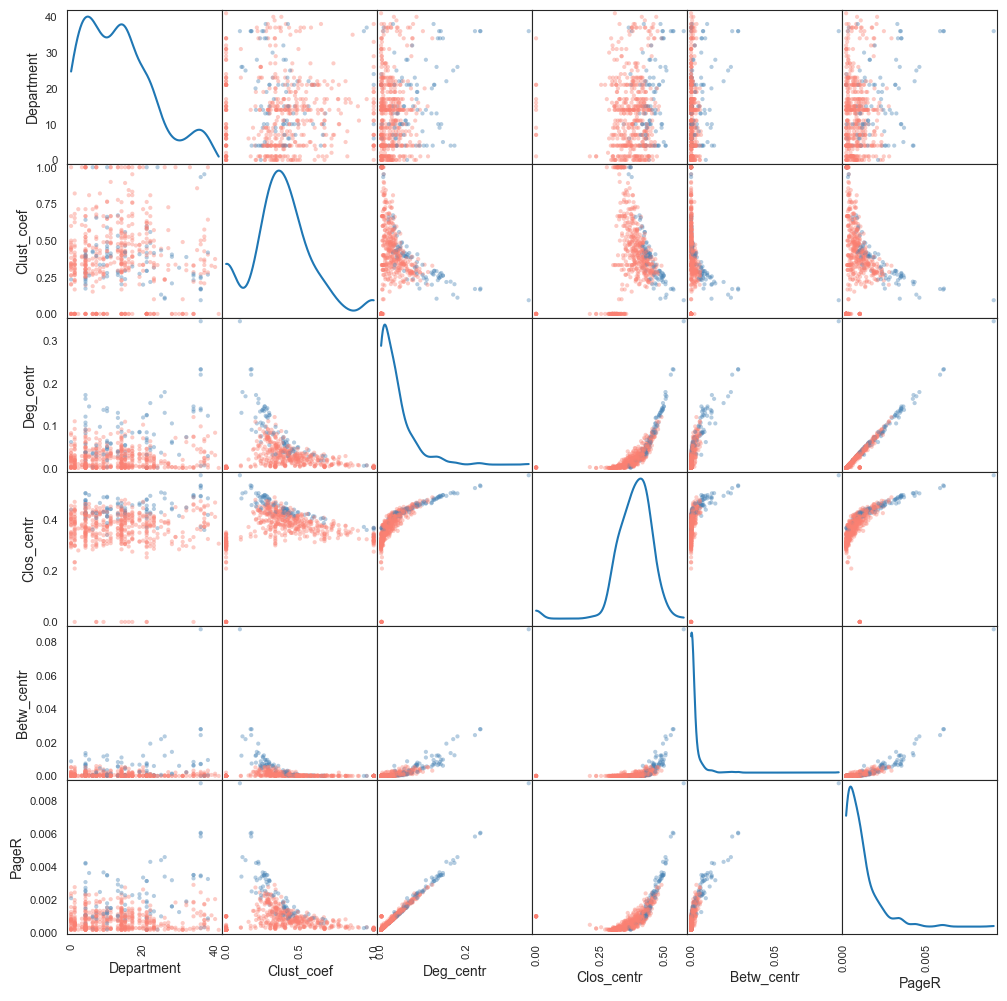

In [11]:
sns.set_style('white')
pd.plotting.scatter_matrix(X_train, alpha=0.4, diagonal = 'kde', c=np.where(y_train==1, 'steelblue', 'salmon'), figsize=(12,12));


<AxesSubplot: >

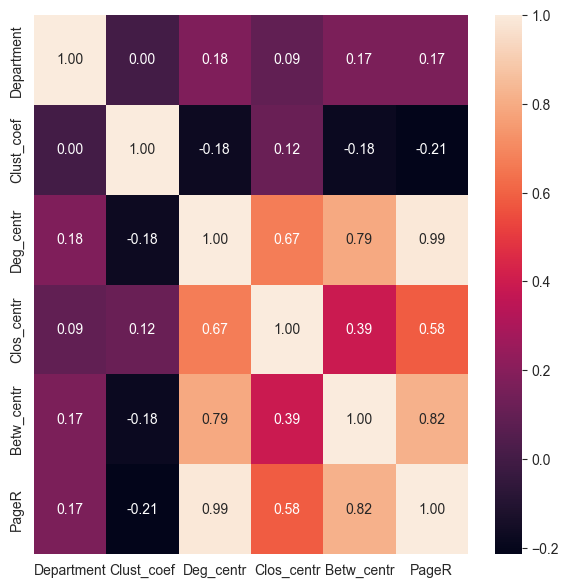

In [12]:
plt.figure(figsize=(7, 7))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')

#### Feature importance with a Decision Tree

Training score:  0.960620774574263
Test score:  0.9264640638864241


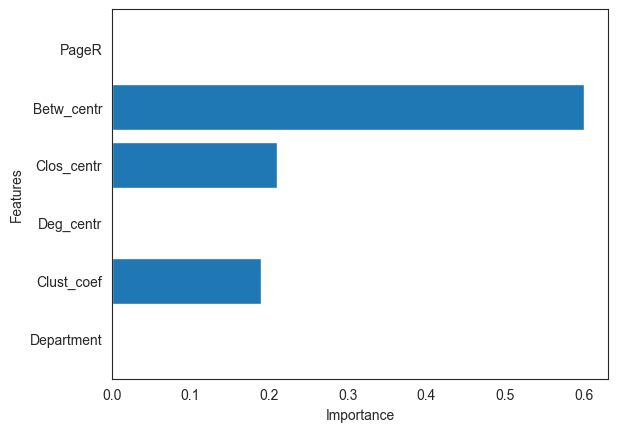

In [13]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=40).fit(X_train, y_train)

plt.figure()
plt.barh(np.arange(len(X.columns)), clf.feature_importances_)
plt.ylabel('Features')
plt.yticks(np.arange(len(X.columns)))
plt.gca().set_yticklabels(list(X.columns))
plt.xlabel('Importance')

print('Training score: ', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print('Test score: ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))


In [14]:
X = df.drop(['Deg_centr', 'PageR', 'Department', 'ManagementSalary'], axis=1)
y = df['ManagementSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Model Selection

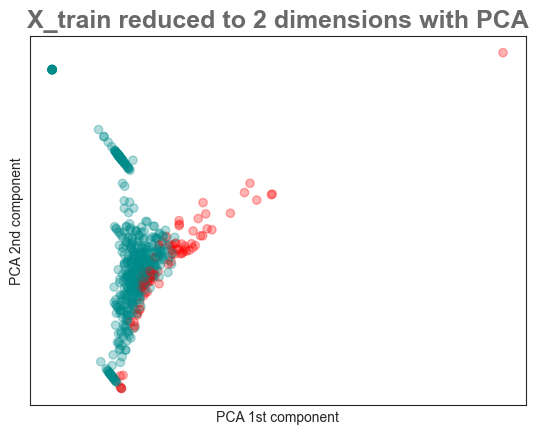

In [15]:
X_normalized = StandardScaler().fit(X_train).transform(X_train)
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train.map({0: 'darkcyan', 1: 'red'}), alpha=0.3)

plt.title('X_train reduced to 2 dimensions with PCA', fontsize=18, color='dimgrey', fontweight='bold')
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel('PCA 1st component')
plt.ylabel('PCA 2nd component');

In [16]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


### SVM

In [18]:
clf = SVC(kernel='linear', C=0.1).fit(X_train_scaled, y_train)

print('Training score: ', roc_auc_score(y_train, clf.decision_function(X_train_scaled)))
print('Test score: ', roc_auc_score(y_test, clf.decision_function(X_test_scaled)))

Training score:  0.9258183676788327
Test score:  0.9174800354924578


### Logistic Regression

In [19]:
clf = LogisticRegression(C=10).fit(X_train_scaled, y_train)

print('Training score: ', roc_auc_score(y_train, clf.decision_function(X_train_scaled)))
print('Test score: ', roc_auc_score(y_test, clf.decision_function(X_test_scaled)))

Training score:  0.9339730037404456
Test score:  0.9008429458740018


In [20]:
np.mean((clf.predict(to_predict.drop(['Deg_centr', 'PageR', 'Department'], axis=1))))

c:\Users\rogha\anaconda3\envs\sin\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.0